Title: Term Project

Author: Chad Wood

Date: 06 June 2022

Modified By: Chad Wood

Description: This is my term perject for my final term in the Data Science undergraduate program at Bellevue University. I attempt to apply reinforcement learning to the Travelling Salesman Problem as a newcommer to both reinforcement learning and spatial data processing. This document demonstrates what I've built  thus far, though I hope readers will also gather from this much of the journey I experienced from building it.

## Proposing a machine learning [approximate] solution for the Travelling Salesman Problem

### What is the Travelling Salesman Problem?

The Travelling Salesman Problem in an NP-hard problem dealing with optimization of a route between N cities, given the distances between each city. For example, if travelling between each state in the United States, it would be infeasible to calculate the shortest possible route via brute force. This is because with 50 states there would be at least 50! possible routes. As a result, optimization methods are highly valuable for approximate a solution for the problem.

### What current approximate solutions exist?

There have been a handful of successful attempts to get exact solutions, though they've required extraordinarily powerful computers and the computation time for a more standard personal computer would be decades. For interested readers, I'd refer you to researching the following instances:

    2001 TSPLIB exact solution of 15112 cities in Germany
    2004 TSP exact solution of 24978 cities in Sweden
    2005 Concorde TSP Solver exact solution of 33,810 nodes in a circuit board
 
With approximations, there exists several techniques that have varying levels of success depending on the distribution of nodes. For example, the nearest neighbor algorithm would have an agent always travel to the next closest target. However, this approximation averages about 25% longer than the most optimal solution--and it is possible in some distributions for this algorithm to return the worst possible route. Alternative approximation algorithms include pairwise exchange, k-opt heuristic, V-opt heuristic, and ant colony optimization. However, each contains their own pros and cons.

### What is my approach?

My approach is to apply machine learning to the Travelling Salesman Problem. I believe this approach is well suited to the problem because the exact algorithm for solving the TSP is still unknown, which an algorithm may be able to approximate better than current methodologies. Given the lack of training data for travelling salesman problems with a high number of cities, I decided that an unsupervised approach would be best.

I also considered how machine learning models often have improved accuracy whether problems are broken down into many fundamental parts. This is the beauty of feature engineering, since breaking down a problem often isn't a straightforward process. In consideration to this, I had the idea that reinforcement learning may be a good choice because it breaks down the problem into node-level choices; that is, a choice is being made on where to go from current position until a solution has been found.

However, not all reinforcement learning approaches are build equal. After looking through several options, I determined that a neural network would likely work best as my machine learning model. This decision was made due to a Neural Networks strength toward high dimensional data. To take things further, I am also looking into implementation of a Graph Neural Network as the model, which is still a very new technology for being applied to reinforcement learning.

Furthermore, I wanted to propose a solution to the variability within approximations. In an effort to increase stability or results, I decided to make the entire process modular enough so that it could be trained on any street map in the road with ease.

### Where I'm at so far

Being a beginner in working with reinforcement learning and spatial data, I've ran into several very difficult problems which required a lot time. As a result, this project will take longer than the originally intended 12 weeks. However, here's where I'm at thus far:

I began by locating a source for street network data, which I discovered is available via Open Street Map. To simplify the process of collecting this network data, I created a class that enables users to query for map data via specified dimensions of a polygon.

C:\Users\mrcha\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


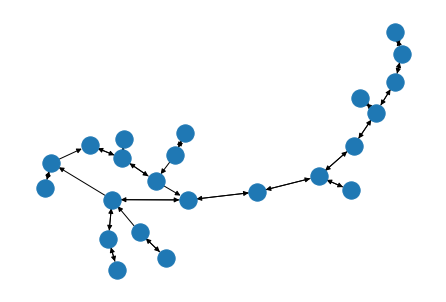

In [1]:
from polypocket import StreetMap
import networkx as nx

# Specified dimensions of polygon
center = (-121.885254, 37.335796) # Real coordinate location
dist = 350 # Meters from center as radius

# Creates polygon with given dimensions
poly = StreetMap(center, dist)

# Plots network
nx.draw(poly.G)

Moving forward, I realized I also needed a way to identify which nodes where houses and which nodes where gas stations. These are important because houses will be used as targets for the agent, and gas stations add a price factor to the route via total cost of gas. Both of these should be usable in a way to better guide the actions of an agent for proposing solutions. However, Open Street Map is missing many attributes for their nodes and edges, so I didn't want to rely on users picking locations that happened to provide complete data. 

To solve this issue, I created a function that will generate random points within the bounds of the polygon. The function will also perform a nearest neighbor search for each random point, and return the nearest neighbor for use as a house. Secondly, the function will select gasstations via a random sample of the nodes.

In [34]:
from polypocket import generate

n_houses = 3 # Houses
n_gasstations = 2 # Gas stations

# Instructs class to generate random coordinate points within polygon
objects = generate(streetmap=poly, houses=n_houses, gasstations=n_gasstations)

In [35]:
import geopandas as gpd

# This utilizes gpd.GeoDataFrame as a wrapper for matplotlib to simplify the visualizations
points = gpd.GeoDataFrame(objects.get('points'), columns=['geometry'])
houses = gpd.GeoDataFrame(objects.get('houses'), columns=['geometry'])
connections = gpd.GeoDataFrame(objects.get('connections'), columns=['geometry'])
gasstations = gpd.GeoDataFrame(objects.get('gasstations'), columns=['geometry'])

<AxesSubplot:>

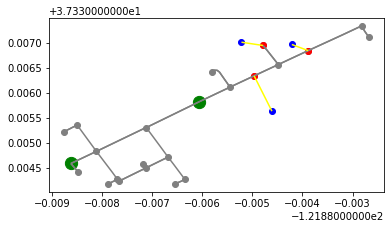

In [36]:
# Plots houses
ax = points.plot(color='blue')

# Plots street network
nodes, edges = poly.nodes, poly.edges
nodes.plot(ax=ax, color='grey')
edges.plot(ax=ax, color='grey')

# Plots nearest nodes to each house
houses.plot(ax=ax, color='red')

# Plots connections to visually represent neighbors
connections.plot(ax=ax, color='yellow')

# Plots gas stations
gasstations.plot(ax=ax, color='green', markersize=150)

As demonstrated via the visualization, 3 random points (blue) have been generated and tethered (yellow) to the map by using their nearest neighbor (red). Certain nodes have also been randomly sampled to serve as gas stations (green). This map is used for is small size to help simplify the demonstration.

The next problem was feature engineering and adjusting data structures for use with a reinforcement learning algorithm. To solve this problem, I created two different Environment classes. Currently only one is properly implemented, though both run. I will be demonstrating the properly implemented version, and the second version (along with its reasoning) can be found in the documentation notebook for Environment.

Class Environment filters through the attributes attached to each edge in order to standardize their labels, but also make sure the representation for each edge can fit inside the same array (i.e., having equal dimensions). To do this, I decided that the most important variables for this array would likely be the edge labels, length, and onehot encoded values for whether the edge travels to a house or gasstation.


In [37]:
from polypocket import Enviroment

# Collects object data structure used by class Enviroment
objects = objects.get('osmids')

# Instantiates enviroment
env = Enviroment(poly.G, objects)

In [38]:
env.norm_flagged_edges

array([[  0.   ,  11.   ,  52.473,   0.   ,   1.   ],
       [  0.   ,  10.   ,  72.482,   0.   ,   0.   ],
       [  0.   ,   1.   , 102.603,   0.   ,   0.   ],
       [  1.   ,   2.   , 110.083,   0.   ,   1.   ],
       [  1.   ,   0.   , 102.603,   0.   ,   0.   ],
       [  2.   ,  19.   ,  62.704,   0.   ,   0.   ],
       [  2.   ,   1.   , 110.083,   0.   ,   0.   ],
       [  3.   ,  15.   ,  27.169,   0.   ,   0.   ],
       [  4.   ,   0.   ,  67.433,   0.   ,   0.   ],
       [  4.   ,   5.   ,  27.143,   0.   ,   0.   ],
       [  5.   ,   4.   ,  27.143,   0.   ,   0.   ],
       [  6.   ,  18.   ,  20.45 ,   0.   ,   0.   ],
       [  7.   ,  16.   ,  55.913,   0.   ,   0.   ],
       [  8.   ,  16.   ,  46.158,   0.   ,   0.   ],
       [  8.   ,   1.   ,  76.243,   0.   ,   0.   ],
       [  9.   ,  10.   ,  18.803,   0.   ,   0.   ],
       [ 10.   ,   7.   ,   4.771,   0.   ,   0.   ],
       [ 10.   ,   9.   ,  18.803,   0.   ,   0.   ],
       [ 11.   ,   0.   ,  5

The above array demonstrates how I planned to provide the environment. The first two columns indicate the start and end node for the edge that row represents. The third column indicates edges length. The fourth column indicates if the edge leads to a house (via column two), and the fifth column indicates if the edge leads to a gasstations (via column two).

And to aid in reversing the label encoding, once an optimal solution has been found, a user can refer to the indexer attribute for a dictionary indicating the original osmid for each label

In [39]:
env.indexer

{65419214: 0,
 65551811: 1,
 281149293: 2,
 577415666: 3,
 3215365365: 4,
 3215365366: 5,
 3217632870: 6,
 3217632933: 7,
 3217632934: 8,
 3217642899: 9,
 3217642900: 10,
 3217642901: 11,
 3217642902: 12,
 3614216318: 13,
 3614216320: 14,
 3614216323: 15,
 3642759799: 16,
 3642759800: 17,
 5286996792: 18,
 5681157297: 19,
 5681157302: 20,
 5919589740: 21,
 5919589742: 22}

Next, I needed to create a way to move through states within the environment, much like a game. I created another class that performs this as such.

In [40]:
from polypocket import State

# Function for providing report on state data
def status_report(state):
    print(f'Position: {state.position}')
    print(f'Gas: {state.gas}')
    print(f'Max Gas: {state.max_gas}')
    print(f'Distance Travelled: {state.distance}')
    print(f'Route Cost: {state.cost}')
    print(f'Remaining Targets: {state.remaining_targets}')
    print(f'Action Space: \n{state.choices}')
    
start = 0 # Starting position (node)
state = State(env, start) # # Instantiates State

status_report(state)

Position: 0
Gas: 20
Max Gas: 20
Distance Travelled: 0
Route Cost: 0
Remaining Targets: [21 14 13]
Action Space: 
[[ 11.     52.473   0.      1.   ]
 [ 10.     72.482   0.      0.   ]
 [  1.    102.603   0.      0.   ]]


It's important to keep in mind that gas, gas cost, fuel efficiency, and other variables are optionally specifiable--though I did not to retain simplicity within the demonstration. These can be passed as arguments, and the State notebook contains thorough documentation on this.

From here, we can see that action space includes a lot on information. For reference, it consists of all nodes where the agent can travel from its current position--inherently requiring that an edge connect the nodes. The action space is a slice of the environment array, making the length and onehot encoded values also available for review. However, this may be further sliced into a one-dimensional array if required by the reinforcement learning algorithm.

Next, I will demonstrate the classes functionality by updating position with random choices until there is optionally a target to travel to.

In [41]:
import numpy as np 

# Bool mask of choices
choices_is_target = np.isin(state.choices[:,0], state.remaining_targets)
target_nearby = any(choices_is_target)

# Updates position randomly until target is nearby
while not target_nearby:
    choice = np.random.choice(state.choices[:,0])
    state.set_position(choice)
    
    # Bool mask of choices
    choices_is_target = np.isin(state.choices[:,0], state.remaining_targets)
    target_nearby = any(choices_is_target)
    
status_report(state)

Position: 19.0
Gas: [19.27777778]
Max Gas: 20
Distance Travelled: [13.]
Route Cost: 0
Remaining Targets: [21 14 13]
Action Space: 
[[13.    49.551  1.     0.   ]
 [ 2.    62.704  0.     1.   ]
 [20.    54.161  0.     0.   ]]


Here, we can see the 'agent' has arrived at a position where it can now travel to a target (13). This is clear when observing how 13 falls in both Remaining Targets and Action Space. Below I will demonstrate the agent travelling to this target, then I will print out the report once more along with the entire route taken

In [42]:
state.set_position(13)

status_report(state)
state.route

Position: 13
Gas: [19.27777778]
Max Gas: 20
Distance Travelled: [13.]
Route Cost: 0
Remaining Targets: [21 14]
Action Space: 
[[22.    49.531  0.     0.   ]
 [19.    49.551  0.     0.   ]]


array([ 0., 11.,  0., 11., 12., 11., 12., 11.,  0., 10.,  9., 10.,  9.,
       10.,  7., 16., 17., 16.,  8.,  1.,  2.,  1.,  2.,  1.,  0., 11.,
        0., 11.,  0., 11., 12., 11., 12., 11.,  0., 11.,  0., 10.,  9.,
       10.,  9., 10.,  7., 16., 17., 16.,  8.,  1.,  2., 19., 13.])

Here, the route is provided as an array indexed by the order in which node n was visited.

### Moving Forward

Given the available amount of time remaining, I will not be submitting the completed project. This is the first time I've found myself in this situation, though I must say I've probably learned more from this project than most others thus far. This project provided me with hands on experience working with spatial data and making valuable decisions on project direction in unfamiliar topics. I've so far built many of the tools needed to finish this project; what's left to do is finish developing the game, create the agent, and implement a reinforcement learning algorithm.

Some considerations I am pondering is using a Deep Q Learning model, which effectively uses a second neural network to help in place of a Q table. I was also looking into modeless reinforcement learning because I felt a model-less design may be more tailored to my goal (i.e., a solution that can be applied to any street network). Lastly, I also wanted to investigate utilizing a Graph Neural Network for this problem because GNNs enable an algorithm to learn directly on a polygon. GNNs have only recently been applied to reinforcement learning, meaning that the technology is still very young. With that in mind, there's potential to find interesting results that may have never been seen before via utilization of a GNN for this problem.

I plan to continue maintaining this project even after getting everything working. I would like to develop this into an entire library that makes working with spatial data and machine learning both easy and intuitive while also offering new tools to help advance the field. That is the ultimate goal of mine.
